In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
import xgboost as xgb

In [3]:
train_df=pd.read_csv('../data/preprocessed/train.csv')
test_df=pd.read_csv('../data/preprocessed/test.csv')

In [4]:
X_train = train_df.drop(["id","rainfall"], axis=1)
y_train = train_df["rainfall"]
X_test = test_df.drop("id",axis=1).copy()

In [5]:
model = xgb.XGBRegressor(
    objective='reg:squarederror', 
    n_estimators=1000,        
    learning_rate=0.05,          
    max_depth=7,        
    subsample=0.8,            
    colsample_bytree=0.8,       
    random_state=42,
    n_jobs=-1, #use all cores available
    tree_method='hist' #performance improvement
    )

model.fit(X_train, y_train,eval_set=[(X_train, y_train)],early_stopping_rounds=50,verbose=False)


/usr/lib/python3/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

In [6]:
y_pred = model.predict(X_test)
submission = pd.DataFrame({
        "id": test_df["id"],
        "rainfall": y_pred
    })
submission.to_csv('../data/submissons/xgboost_submission.csv', index=False)
print("Submission saved")

Submission saved


In [7]:
# saving the model
import pickle
pickle.dump(model, open("../models/xgboost_model.pkl", "wb"))
print("Model saved")

Model saved


In [8]:
#model performance mesuure on training data
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import cross_val_predict,cross_val_score

In [9]:
# Convert continuous target feature to binary integer feature
y_train= (y_train >= 0.5).astype(int)

In [10]:
pred=cross_val_predict(model, X_train, y_train, cv=3) 
y_pred_train = (pred >= 0.5).astype(int)

In [11]:
cm=confusion_matrix(y_train, y_pred_train)
print("Confusion Matrix: ", cm)

Confusion Matrix:  [[ 344  196]
 [ 129 1521]]


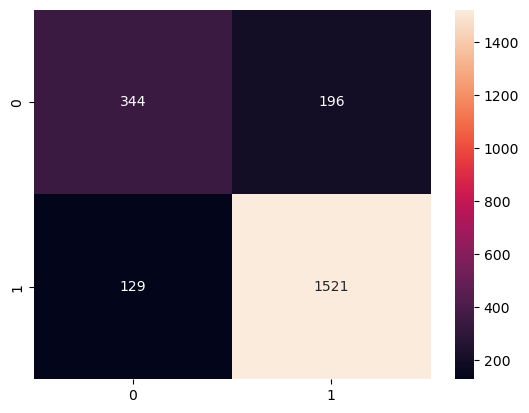

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(cm, annot=True, fmt="d")
plt.show()

In [13]:
print("Precision: ", precision_score(y_train, y_pred_train))
print("Recall: ", recall_score(y_train, y_pred_train))
print("F1 Score: ", f1_score(y_train, y_pred_train))
print("ROC AUC Score: ", roc_auc_score(y_train, y_pred_train))

Precision:  0.8858474082702388
Recall:  0.9218181818181819
F1 Score:  0.9034749034749034
ROC AUC Score:  0.7794276094276096


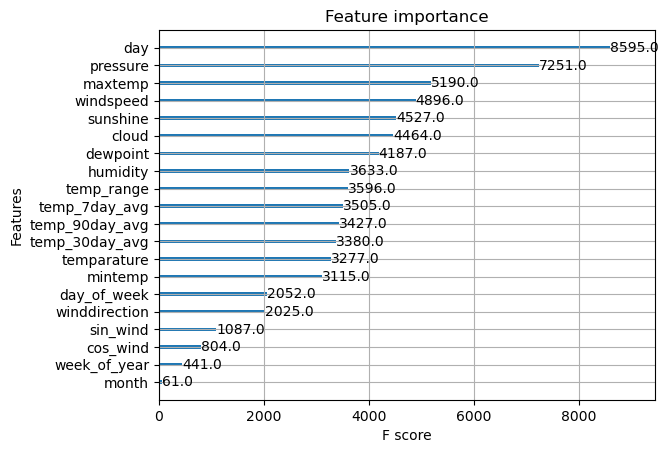

In [14]:
#plotting feature importance
import matplotlib.pyplot as plt
xgb.plot_importance(model)
plt.show()

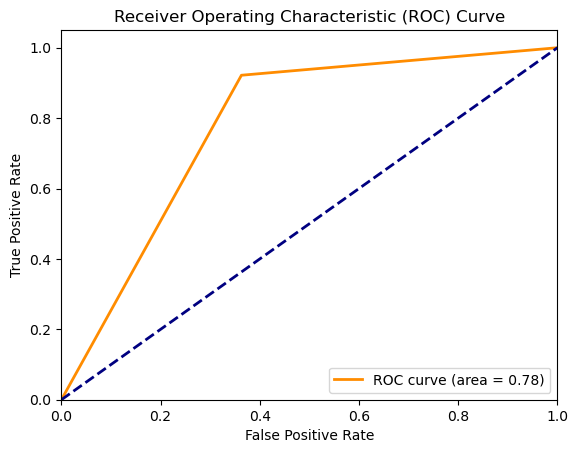

In [15]:
from sklearn.metrics import roc_curve, auc

# Calculate the ROC curve
fpr, tpr, _ = roc_curve(y_train, y_pred_train)

# Calculate the AUC
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()